# olivine-melt Fe-Mg Kd

In this notebook we benchmark MagmaPandas olivine-melt Fe-Mg Kd codes by reproducing calculations and/or figures from literature. When possible, we compare MagmaPandas results to results from codes or data provided with the original publication of the model. Unfortunately, in many cases these are not available, in which case we've compiled the input data ourselves. In these cases, we cannot be 100% sure that we use exacly the same input data and small differences between MagmaPandas results and data in published figures are expected.

In [1]:
import MagmaPandas as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import geoplot as gp

from scipy.constants import R

from MagmaPandas.Kd.Ol_melt.FeMg.Kd_models import *
from MagmaPandas.Fe_redox.Fe3Fe2_models import borisov2018
from MagmaPandas.model_calibrations import get_calibration_data

from MagmaPandas.tools.modify_compositions import _remove_elements

mm = 1 / 25.4

### Toplis et al. (2005)

This model uses equation 10 from {cite:t}`toplis_thermodynamics_2005`. We test our implementation by reproducing figure 15. Here we use a simplified version of toplis' eq. 10. This equation takes the ratios of Fe and Mg activity coefficients as input, instead of the adjusted SiO2 parameter. Otherwise this function is the same as the ``calculate_Kd`` method from ``toplis2005`` in MagmaPandas.

In [2]:
def get_T_solidus(P_GPa):
    return (-6.435 * P_GPa**2 + 146.533*P_GPa + 1096.154) + 273.15

def toplis_simplified(T_K, P_bar, forsterite, gFegMg):
     return np.exp(
                (-6766 / (R * T_K) - 7.34 / R)
                + np.log(gFegMg)
                + (3000 * (1 - 2 * forsterite) / (R * T_K))
                + (0.035 * (P_bar - 1) / (R * T_K)))

In [3]:
pressures = np.linspace(1, 1e5, 100)
T_solidus = get_T_solidus(pressures / 1e4)
forsterite = 0.9

In [4]:
Kd_toplis = pd.DataFrame(index=pressures)

for g_ratio in (1.5, 1.3):
    Kd_toplis[g_ratio] = toplis_simplified(
        T_K=T_solidus, P_bar=pressures, forsterite=forsterite, gFegMg=g_ratio
    )

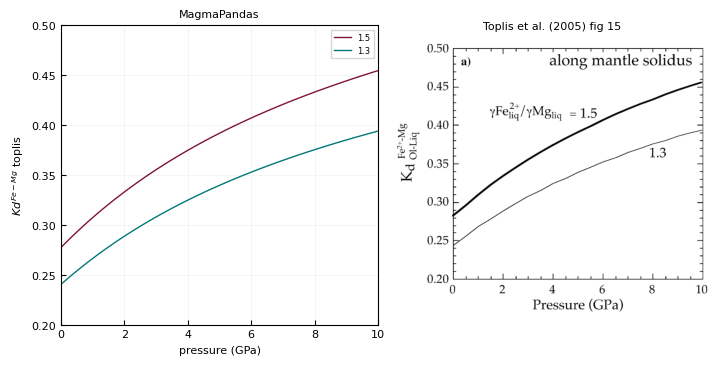

In [5]:
mm = 1/25.4
gp.layout(colors=gp.colors.bella)

fig, axs = plt.subplots(1, 2, figsize=(180*mm, 90*mm))

for g, Kd_series in Kd_toplis.items():
    axs[0].plot(pressures / 1e4, Kd_series, "-", label=g)


axs[0].set_xlim(0, 10)
axs[0].set_ylim(0.2, 0.5)
axs[0].legend(frameon=True, fancybox=False)

axs[0].set_xlabel("pressure (GPa)")
axs[0].set_ylabel("$Kd^{Fe-Mg}$ toplis")
axs[0].set_title("MagmaPandas")

img = mpimg.imread("./data/Kd/Kd_toplis2005_fig15.png")
axs[1].imshow(img)
axs[1].axis("off")

axs[1].set_title("Toplis et al. (2005) fig 15")

plt.show()

### Blundy et al. (2020)

This model uses equation 8 from {cite:t}`blundy_effect_2020`. To validate our code we calculate Kd values with the dataset provided by the paper and compare results with fig. 9. If the code is correct, calculated values should plot on the regressed line (red).

In [6]:
blundy_input_file = "./data/Kd/Kd_blundy2020_input.csv"
blundy_input = pd.read_csv(blundy_input_file, index_col=[0])
blundy_input = blundy_input.query("(olivine_forsterite.notna()) & (_Fe3Fe2.notna())")

compositions_blundy = mp.Melt(blundy_input.iloc[:, :12], units="wt. %", datatype="oxide")

The default ``calculate_Kd`` method of blundy2020 calculates melt Fe3/Fe2 ratios with provided fO2 values and the borisov2018 model. Here we use ``_calculate_Kd`` instead, where melt Fe3/Fe2 and olivine forsterite content measured in the experiments are directly provided as input.

In [7]:
Kd_Fe2_blundy = blundy2020._calculate_Kd(forsterite=blundy_input["olivine_forsterite"], T_K=blundy_input["T_K"], Fe3Fe2=blundy_input["_Fe3Fe2"])
Kd_Fetotal_blundy = Kd_Fe2_blundy * (1 - blundy_input["_Fe3Fetotal"])

Apply eq. 7 to obtain Kd corrected for non-ideality

In [8]:
Kd_Fetotal_ideal_blundy = Kd_Fetotal_blundy / np.exp(
    (2.6e3 * (1 - 2 * blundy_input["olivine_forsterite"])) / (R * blundy_input["T_K"])
)

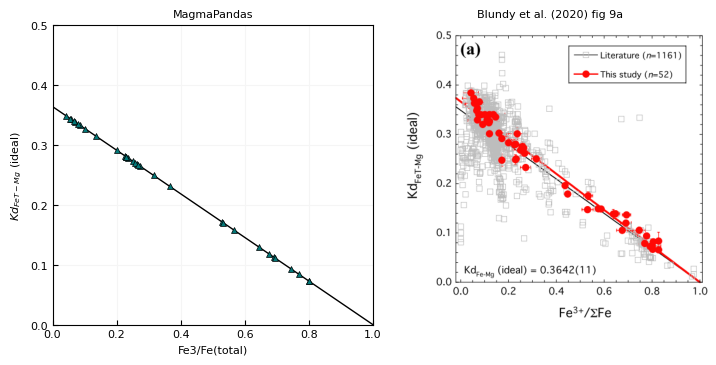

In [9]:
mm = 1/25.4
gp.layout(colors=gp.colors.bella)

fig, axs = plt.subplots(1, 2, figsize=(180*mm, 90*mm))

axs[0].plot((0,1), (0.3642, 0), "-", c="k")
axs[0].plot(blundy_input["_Fe3Fetotal"], Kd_Fetotal_ideal_blundy, lw=0.)

axs[0].set_ylim(0, 0.5)
axs[0].set_xlim(0, 1)

axs[0].set_xlabel("Fe3/Fe(total)")
axs[0].set_ylabel("$Kd_{FeT-Mg}$ (ideal)")
axs[0].set_title("MagmaPandas")

img = mpimg.imread("./data/Kd/Kd_blundy2020_fig9a.png")
axs[1].imshow(img)
axs[1].axis("off")

axs[1].set_title("Blundy et al. (2020) fig 9a")

plt.show()

Calculated Kds fall exactly on the regressed line from fig. 9a and the code therefore works as expected.

### Putirka (2016), eqs 8a-d

Eqs. 8a-d from {cite:t}`Putirka2016` are all linear equations based on liquid compositions in oxide wt.% . They require no data processing (e.g. mole and/or cation conversion) and are very straightforward to calculate. We therefore do not provide benchmarking for these models.

eq. 8a

$$Kd = 0.33$$

eq. 8b

$$Kd =0.21 + 8\cdot10{-3}P(GPa) + 2.5\cdot10^{-3}SiO_2\ wt.\% - 3.63\cdot10^{-4} (Na_2O+K_2O\ wt.\%)$$

eq. 8c

$$Kd = 0.25 + 1.8\cdot10^{-3} SiO_2\ wt.\% - 3.27\cdot10^{-4}(Na_2O + K_2O\ wt.\%)$$

eq. 8d

$$Al\# = Al_2O_3\ wt.\% / (Al_2O_3\ + SiO_2\ wt.\%)$$

$$
Kd = 0.6 + 1.3\cdot10^{-2}\ P(GPa) + 1.6\cdot10^{-2}\ SiO_2\ wt.\% - 1.73\cdot10^{-4}\ SiO_2\ wt.\%^2 + 

1.79\cdot10^{-2} Al_2O_3\ wt.\% - 2.6 Al\# + 2.11\cdot10^{-1}ln(Al\#) + 3.19\cdot10^{-5} (Na_2O + K_2O\ wt.\%)^3

$$



### Sun et al. (2020)

{cite:t}`Sun2020a` provide an excelsheet in the supplementary files that calculates equilibrium olivine forsterite contents with Fe-Mg Kds from eq. 7. Using these forsterite contents and melt Mg#'s, we recalculated Kd's and compared those to magmapandas results calculated with eq. 7.

In [ ]:
calibration_sun = get_calibration_data(parameter="Kd", model="sun2020").set_index("run", drop=True)
# only use the elements included in the excel sheet
elements = [
    "SiO2",
    "TiO2",
    "Al2O3",
    "Cr2O3",
    "FeO",
    "MnO",
    "MgO",
    "CaO",
    "Na2O",
    "K2O",
    "P2O5",
    "NiO",
    "H2O",
    "CO2",
]
compositions_sun = mp.Melt(calibration_sun.loc[:,elements], units="wt. %", datatype="oxide")
compositions_sun = compositions_sun.fillna(0.)

Kd_sun_file = "./data/Kd/Kd_sun2020.csv"
Kd_sun = pd.read_csv(Kd_sun_file, index_col=[0])

The sun excelsheet calculated Kds with Fe(total), while magmapandas uses inputted Fe3/Fe2 ratios to convert to Fe2+ Kds. Here we use a fixed Fe3/Fe2 ratio of 0.2 to convert the magmapandas Kds back to Fe(total).

In [11]:
Fe3Fe2 = 0.2
Fe3Fetotal = Fe3Fe2 / (1+Fe3Fe2)

Kd_Fe2_sun_magmapandas = sun2020.calculate_Kd(melt_mol_fractions=compositions_sun.moles(), Fe3Fe2=Fe3Fe2)
Kd_Fetotal_sun_magmapandas = Kd_Fe2_sun_magmapandas * (1 - Fe3Fetotal)

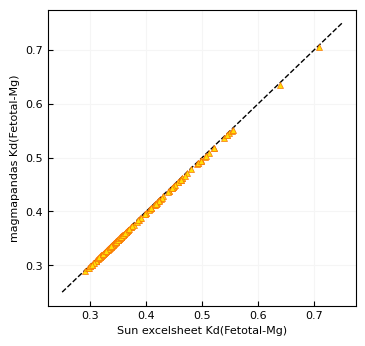

In [12]:
mm = 1 / 25.4
gp.layout(colors=gp.colors.bright)

fig, ax = plt.subplots(figsize=(90 * mm, 85 * mm))

ax.plot((0.25, 0.75), (0.25, 0.75), "--", c="k")
ax.plot(Kd_sun["Kd_Fetotal"], Kd_Fetotal_sun_magmapandas, lw=0.)

ax.set_xlabel("Sun excelsheet Kd(Fetotal-Mg)")
ax.set_ylabel("magmapandas Kd(Fetotal-Mg)")


plt.show()

### Saper et al. (2022)

MagmaPandas implements eq. 2 with model 2 parameter values from {cite:t}`Saper2022`. To validate our code, we reproduce fig. 6a from the original paper, using data from tables 2 and 3 as input. In this figure, melt Fe2+ is calculated with the Borisov et al. (2018) model.

In [13]:
data_file = "./data/Kd/Kd_saper2022_table3_glass.csv"
data= pd.read_csv(data_file, index_col=[0])

# data = data.query("run_type == 'E'")
compositions = mp.Melt(data.iloc[:,7:-1], units="wt. %", datatype="oxide")

In [14]:
Fe3Fe2_saper = borisov2018.calculate_Fe3Fe2(
    melt_mol_fractions=compositions.moles(), T_K=data["T_K"], fO2=data["fO2"]
)
Fe3Fetotal_saper = Fe3Fe2_saper / (1 + Fe3Fe2_saper)

data["Kd_Fe2Mg_measured"] = data["Kd_FeTMg"] / (1 - Fe3Fetotal_saper)
data["Kd_Fe2Mg_predicted"] = saper2022.calculate_Kd(
    melt_mol_fractions=compositions.moles(), T_K=data["T_K"], Fe3Fe2=Fe3Fe2_saper
)

/Users/thomas/Dropbox/research/python/packages/MagmaPandas/src/MagmaPandas/parse_io/parse.py:61: UserWarning: P2O5 missing in composition and set to 0.
  w.warn(


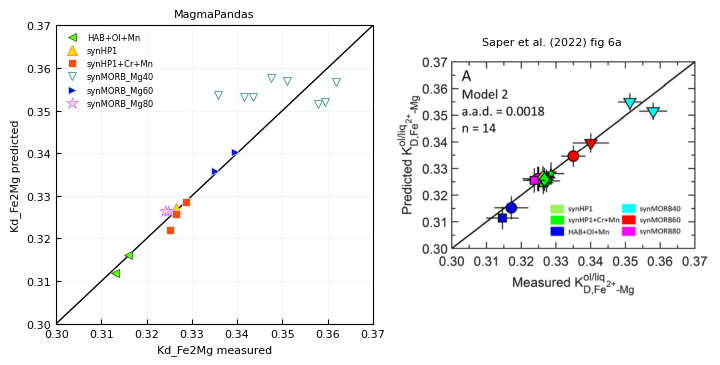

In [15]:
mm = 1 / 25.4
limits = (0.3, 0.37)

gp.layout(colors=gp.colors.bright)
markers = gp.markers
colors = gp.colors.bright.by_key()["color"]
edgecolors = gp.colors.bright.by_key()["markeredgecolor"]
markersizes = gp.marker_sizes * 6


fig, axs = plt.subplots(1, 2, figsize=(180 * mm, 90 * mm))

axs[0].plot(limits, limits, "-", c="k")
for i, (compositions, df) in enumerate(data.groupby("starting_composition")):
    if all((df["T_K"] - df["T_K"].iloc[0]) == 0):
        axs[0].plot(
            df["Kd_Fe2Mg_measured"],
            df["Kd_Fe2Mg_predicted"],
            markers[i],
            ms=markersizes[i],
            c=colors[i],
            mec=edgecolors[i],
            label=compositions,
        )
    else:
        for T, df_2 in df.groupby("T_K"):
            axs[0].plot(
                df_2["Kd_Fe2Mg_measured"].mean(),
                df_2["Kd_Fe2Mg_predicted"].mean(),
                markers[i],
                ms=markersizes[i],
                c=colors[i],
                mec=edgecolors[i],
                label=compositions,
            )

handles, labels = axs[0].get_legend_handles_labels()
legend_dict = dict(zip(labels, handles))
axs[0].legend(legend_dict.values(), legend_dict.keys())

axs[0].set_ylim(*limits)
axs[0].set_xlim(*limits)


axs[0].set_xlabel("Kd_Fe2Mg measured")
axs[0].set_ylabel("Kd_Fe2Mg predicted")
axs[0].set_title("MagmaPandas")

img = mpimg.imread("./data/Kd/Kd_saper2022_fig6a.png")
axs[1].imshow(img)
axs[1].axis("off")

axs[1].set_title("Saper et al. (2022) fig 6a")

plt.show()

Note that the plot shows averages per temperature for the various starting compositions. However, for synMORB Mg40 compositions it is unclear how the data were grouped and these are left as individual points in our plot